In [1]:
# Import Tensorflow 2.0
import tensorflow as tf

import IPython
import functools
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import mitdeeplearning as mdl
import cv2 as cv
import funcs as ff

# check that the environment is fine
print('tf version : ', tf.__version__ )
print('np version : ', np.__version__ )
print('opencv version', cv.__version__)


tf version :  2.3.0
np version :  1.19.2
opencv version 4.5.1


In [2]:
# ###############
# DATASET CREATION
# ###############

#data import

import pathlib
import tensorflow_datasets as tfds

img_h = 128
img_w = 128

batch_size = 64

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, 
                                   fname='flower_photos', 
                                   untar=True)
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=1234,
  image_size=(img_h, img_w),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=1234,
  image_size=(img_h, img_w),
  batch_size=batch_size)

class_names = train_ds.class_names
print('class names : ', class_names)

# checking that the dataset has the expected shape
for batch, labels in train_ds:
    print('train_ds batch shape : ', batch.shape)
    print('train_ds labels shape : ', labels.shape)
    break

for batch, labels in val_ds:
    print('valid_ds batch shape : ', batch.shape)
    print('valid_ds labels shape : ', labels.shape)
    break

3670
Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.
class names :  ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
train_ds batch shape :  (64, 128, 128, 3)
train_ds labels shape :  (64,)
valid_ds batch shape :  (64, 128, 128, 3)
valid_ds labels shape :  (64,)


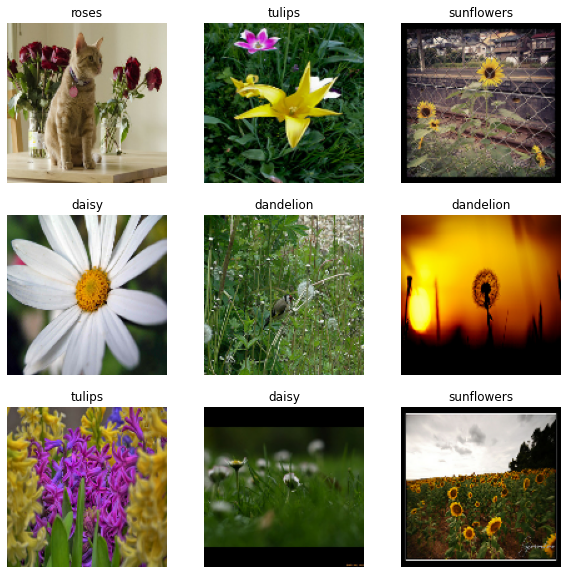

In [3]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [4]:
# ###############
# Model
# ###############
print(np.random.choice(1000, 3))
vae = ff.VAE(latent_dim=100)
vae.Summary()

[267 393 379]
model created, maybe even sucessfully
Encoder : 
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (1, 128, 128, 8)          224       
_________________________________________________________________
re_lu (ReLU)                 (1, 128, 128, 8)          0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (1, 64, 64, 8)            0         
_________________________________________________________________
conv2d_1 (Conv2D)            (1, 64, 64, 16)           1168      
_________________________________________________________________
re_lu_1 (ReLU)               (1, 64, 64, 16)           0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (1, 32, 32, 16)           0         
_________________________________________________________

In [ ]:
# ###############
# TRAINING LOOP FUNCTIONS
# ###############
lr = 5e-4
epochs = 10
optimizer = tf.keras.optimizers.Adam(lr)

''' Function to calculate VAE loss given:
      an input x,
      reconstructed output x_recon,
      encoded means mu,
      encoded log of standard deviation logsigma,
      weight parameter for the latent loss kl_weight
'''
def loss_func(x, x_recon, mu, logsigma, kl_weight=0.0005):

    latent_loss = 0.5 * tf.reduce_sum(
      tf.math.exp(logsigma) + tf.math.pow(mu, 2) - 1 - logsigma,
      axis=1
    )

    reconstruction_loss = tf.reduce_mean(tf.math.abs(x - x_recon), axis=(1,2,3))
    vae_loss = kl_weight*latent_loss + reconstruction_loss

    return vae_loss

# Training step with gradient tapes
@tf.function
def vae_train_step(x, y, optimizer):

  with tf.GradientTape() as tape:
    # Feed input x into dbvae. Note that this is using the DB_VAE call function!
    y_logit, z_mean, z_logsigma, x_recon = vae(x)
    loss, class_loss = loss_func(x, x_recon, z_mean, z_logsigma, kl_weight=.5)

  grads = tape.gradient(loss, vae.trainable_variables)

  # apply gradients to variables
  optimizer.apply_gradients(zip(grads, vae.trainable_variables))
  return loss

# actual training loop
for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    train_step(model, train_x, optimizer)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for test_x in test_dataset:
    loss(loss_func(model, test_x))
  vae_loss = -loss.result()
  display.clear_output(wait=False)
  print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, vae_loss, end_time - start_time))
# generate_and_save_images(model, epoch, test_sample)
